# Color GAN
*   **Goal:** Black & white to rgb images
*   **Dataset:** ImageNet/COCO-dataset

# Algorithm
*   **Cost function V(D,G):** log(D(x)) + log(1- D(G(x))), could possibly add a l1 norm accounting for the difference between groundtruth image and generated image
*   **Discrimnator (D):** maximize cost function (be able to give high probability for real x vs. generated x)
*   **Generator (G):** minimize the cost function (confuses discriminator such that discriminator gives lower probability for real x vs. generated x, e.g. 50%)
*   **Optimization:** use minibatch, ADAM optimizer (lr = 0.0001 or .00005,
momentum β1 = 0.5, β2 = 0.999.)
*   **Regularization:** try both L1 & L2 for G


In [1]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [2]:
# Import packages
import numpy as np
import math
import os
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
from torch.utils import data
from torch.nn.utils import spectral_norm
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import torch.optim as optim
from torch.autograd import Variable
print(torch.__version__) # 1.0.1
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy(), interpolation='nearest')
    plt.axis("off")
        

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
1.7.0+cu101


In [8]:
# make sure go to the project path
project_path = "/gdrive/MyDrive/Colab Notebooks/GAN"
os.chdir(project_path)
!ls

Beach				Colorizer.ipynb
Buildings			Colorizer_results_1000.png
Color_GAN_Nicole.ipynb		Colorizer_results_100.png
Colorizer_D_1000_05-26.pth.tar	Colorizer_results_1200.png
Colorizer_D_100_05-27.pth.tar	Colorizer_results_1400.png
Colorizer_D_1200_05-26.pth.tar	Colorizer_results_200.png
Colorizer_D_1400_05-26.pth.tar	Colorizer_results_500.png
Colorizer_D_200_05-27.pth.tar	Colorizer_results_50.png
Colorizer_D_700_05-26.pth.tar	Colorizer_results_600.png
Colorizer_D_800_05-26.pth.tar	Colorizer_results_700.png
Colorizer_G_1000_05-26.pth.tar	Colorizer_results_800.png
Colorizer_G_100_05-27.pth.tar	Dataset
Colorizer_G_1200_05-26.pth.tar	Flower
Colorizer_G_1400_05-26.pth.tar	Images
Colorizer_G_200_05-27.pth.tar	LOSS.p
Colorizer_G_50_05-27.pth.tar	Nature
Colorizer_G_700_05-26.pth.tar	small_Color_GAN_Nicole.ipynb
Colorizer_G_800_05-26.pth.tar


In [4]:
# CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## Load Dataset

In [ ]:
#download cocodataset into google drive
# !wget http://images.cocodataset.org/zips/train2017.zip
# !unzip train2017.zip

In [9]:
# load_data
def load_data(data_folder, batch_size, train):
  '''
    PARAMETERS: 
      data_folder: path to dataset (make sure you're in project folder)
      batch_size: how many images in a batch
      train: boolean True/False

    RETURN:
      data_loader with random sample with batch_size from either "train" or "test" dataset
  '''
  transform = {
    'train': transforms.Compose(
        [transforms.Resize([64, 64]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                   std=[0.229, 0.224, 0.225])
            ]),
    'test': transforms.Compose(
        [transforms.Resize([64, 64]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                   std=[0.229, 0.224, 0.225])
            ])
  }
  data = torchvision.datasets.ImageFolder(root = data_folder, transform=transform['train' if train else 'test'])
  data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=4)
  return data_loader 

In [10]:
b_size = 128
# set up datafolder and read data
datafolder = "Dataset"
train_data = load_data(data_folder = datafolder, batch_size = b_size , train = True)  #128 training images
test_data = load_data(data_folder = datafolder, batch_size = b_size , train = False)  

# dataiter for iterating data randomly 
train_dataiter = iter(train_data)
test_dataiter = iter(test_data)

In [ ]:
train_real, labels = train_dataiter.next() #get one batch of train data
test_real, labels = test_dataiter.next()
print(train_real.shape) # images are in batch_size x channels(3) x width x height

torch.Size([128, 3, 64, 64])


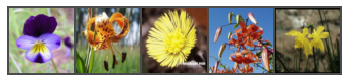

In [ ]:
show_imgs(train_real[0:5,:,:,:])  #example of train data

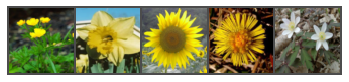

In [ ]:
show_imgs(test_real[0:5,:,:,:]) 

### Discriminator

In [ ]:
class Discriminator_Nicole(torch.nn.Module):
    def __init__(self, inp_dim= 4*64*64, alpha=0.2, kernel_size = 4, padding = 1, stride = 1):
        super(Discriminator_Nicole, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Dropout(0.25),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Dropout(0.25),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Dropout(0.5),
            nn.MaxPool2d(2)
            
        )
        self.prelu = nn.PReLU()
        self.drop = nn.Dropout(.5)
        self.fc1 = nn.Linear(256*6*6, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
      x = self.net(x)
      x = x.view(x.size(0), 256*6*6) #flattening x
      x = self.fc1(x)
      x = self.prelu(x)
      x = self.drop(x)
      x = self.fc2(x)
      x = torch.sigmoid(x.squeeze())
      return x

    def weight_initial(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            if isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

In [ ]:
D = Discriminator_Nicole()
D.weight_initial()
train_real, labels = train_dataiter.next() 
images = train_real.clone().cpu() 
images = [torchvision.transforms.ToPILImage()(x) for x in images]
images = [torchvision.transforms.Grayscale()(x) for x in images]
images = [torchvision.transforms.ToTensor()(x) for x in images]
train_real_gray = torch.stack(images)

# D Loss for real
# n = (torch.randn(train_real_gray.size()) * .1) # add noise to image to make it harder for discriminator
train_real = torch.cat((train_real, train_real_gray), 1)
print(train_real.shape)

output = D(train_real)
print(output.shape)


torch.Size([128, 4, 64, 64])
torch.Size([128])


### Generator

In [ ]:
class Generator_Nicole(nn.Module):
  def __init__(self, input_size = 64*64, alpha = .2, kernel_size = 3, padding = 1, output_padding = 1, stride = 1):
    super(Generator_Nicole, self).__init__()

    self.conv1 = nn.Sequential(
            nn.Conv2d(1+1, 16, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(alpha)
            )

    
    self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(alpha),
            nn.MaxPool2d(2)
            )
    
    self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(alpha),
            nn.MaxPool2d(2)
            )
    
    self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha)
            )
    
    self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha)
            )
    
    self.conv6 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha)
            )
    
    self.conv7 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(64),
            # nn.ReLU())
            nn.LeakyReLU(alpha)
            )
    
    self.conv8 = nn.Sequential(
        nn.Conv2d(64+2, 32, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(32),
        # nn.ReLU())
        nn.LeakyReLU(alpha))
    
    self.conv9 = nn.Sequential(
        nn.Conv2d(32, 3, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(3),
        # nn.ReLU())
        nn.LeakyReLU(alpha))
        
    self.upsample = nn.Upsample(scale_factor=2)
  

  def forward(self, x):
    x_n = x
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.upsample(x)
    x = self.conv6(x)
    x = self.upsample(x)
    x = self.conv7(x)
    x = torch.tanh(x)
    x = torch.cat((x, x_n),1)
    x = self.conv8(x)
    x = self.conv9(x)

    x = torch.tanh(x)
    return x

  def weight_initial(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          m.weight.data.normal_(0, math.sqrt(2. / n))
      if isinstance(m, nn.ConvTranspose2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          m.weight.data.normal_(0, math.sqrt(2. / n))

In [ ]:
G = Generator_Nicole()
images = train_real.clone().cpu() 
images = [torchvision.transforms.ToPILImage()(x) for x in images]
images = [torchvision.transforms.Grayscale()(x) for x in images]
images = [torchvision.transforms.ToTensor()(x) for x in images]
train_real_gray = torch.stack(images)
n = (torch.randn(train_real_gray.size()) * .1)

x = torch.cat((train_real_gray, n), 1)
o = G(x)
print(o.shape)

# img = o[4,:,:,:].detach().squeeze()
# print(img.shape)
# plt.imshow(img.permute(1, 2, 0))

torch.Size([128, 3, 64, 64])


## Training

In [ ]:
def train(D, G, D_opt, G_opt, criterion, recon_loss, lmbda, num_e_s, num_e_e, datasetname = None):
  '''
  PARAMTER:
    D: discriminator
    G: generator
    D_opt: discriminator Optimizer
    num_e_s: start of number of epoches
    num_e_e: end of number of epoches
  '''
  
  LOSS = {}
  LOSS["D_loss"] = []
  LOSS["G_loss"] = []
  # LOSS["D_grad_spar"] = []
  # LOSS["G_grad_spar"] = []

  LOSS["D_loss_val"] = []
  LOSS["G_loss_val"] = []

  for e in np.arange(num_e_s, num_e_e):

    ##### PART I  Train #####

    D.train()
    G.train()
    train_dataiter = iter(train_data)
    print("epoch: %d start" % (e+1))

    D_loss = []
    D_grad_spar = []
    D_out_real = []
    D_out_fake = []
    G_loss = []
    G_grad_spar = []

    iter_train = 0
    for train_real, _ in train_dataiter: 
      iter_train += 1
      b_size = train_real.shape[0]
      ##############
      # D Training #
      ##############
      D_opt.zero_grad()
      train_real = train_real.to(device)
      # label smooth
      if iter_train %4 != 0: 
        lab_real, lab_fake = torch.FloatTensor(b_size).uniform_(.8,1).to(device), torch.FloatTensor(b_size).uniform_(0,.2).to(device)
      else: #1 real, 0 fake
        lab_real, lab_fake = torch.FloatTensor(b_size).uniform_(0,.2).to(device), torch.FloatTensor(b_size).uniform_(.8,1).to(device)

      # lab_real, lab_fake = torch.ones(b_size, 1, device=device), torch.zeros(b_size, 1, device=device) #labels 
      # corresponding grayscale images
      images = train_real.clone().cpu() 
      images = [torchvision.transforms.ToPILImage()(x) for x in images]
      images = [torchvision.transforms.Grayscale()(x) for x in images]
      images = [torchvision.transforms.ToTensor()(x) for x in images]
      train_real_gray = torch.stack(images).to(device)
      n_size = train_real_gray.size()

      # D Loss for real
      n = (torch.randn(n_size) * .1) # add noise to image to make it harder for discriminator
      n = n.to(device)
      train_real = train_real + n
      train_real_origgray = torch.cat((train_real, train_real_gray), 1)
      D_out = D(train_real_origgray)
      lossD_real = criterion(D_out, lab_real)      

      # D Loss for fake
      n = (torch.randn(n_size) * .1)
      n = n.to(device)
      train_real_gray_G = torch.cat((train_real_gray, n), 1)
      G_fake_out = G(train_real_gray_G)
      
      n = (torch.randn(n_size) * .1) # add noise to image to make it harder for discriminator
      n = n.to(device)
      G_fake_out = G_fake_out + n
      G_fake_out_origgray = torch.cat((G_fake_out, train_real_gray), 1)
      D_fake_out = D(G_fake_out_origgray.detach())
      lossD_fake = criterion(D_fake_out, lab_fake)

      # D Loss total
      lossD = lossD_real + lossD_fake
      lossD.backward()
      D_opt.step()

      D_out_real.append(D_out)
      # print("D_out_real: %f" % D_out.mean())
      D_out_fake.append(D_fake_out)
      # print("D_out_fake: %f" % D_fake_out.mean())
      D_loss.append(lossD)
      # print("D_loss: %f" % lossD)
      sparsity = []
      for param in D.parameters():
        spars = 1 - len(param.grad[abs(param.grad)>.001])/len(param.grad.view(-1,1))
        sparsity.append(spars)
      D_grad_spar.append(torch.mean(torch.tensor(sparsity))) #mean sparsity


      ##############
      # G Training #
      ##############
      G_opt.zero_grad()

      # G Loss + content norm Loss between generated rgb image and groundtruth image
      D_G_out = D(G_fake_out_origgray)
      lossG = criterion(D_G_out, lab_real) #Loss for GAN LOSS

      #content loss for each color channel
      lossG_content = 0
      for channel in range(3):
        lossG_content += recon_loss(G_fake_out[:,channel,:,:], train_real[:,channel,:,:]) #Loss for output rgb and real rgb image
      LossGAN_content = lossG + lmbda * lossG_content
      LossGAN_content.backward()
      G_opt.step()

      G_loss.append(LossGAN_content)
      # print("G_loss: %f" % LossGAN_L1)

      # sparsity = []
      # for param in G.parameters():
      #   spars = 1 - len(param.grad[abs(param.grad)>.001])/len(param.grad.view(-1,1))
      #   sparsity.append(spars)
      # G_grad_spar.append(torch.mean(torch.tensor(sparsity))) #mean sparsity

    LOSS["D_loss"].append(torch.mean(torch.stack(D_loss)))
    LOSS["G_loss"].append(torch.mean(torch.stack(G_loss)))
    # LOSS["D_grad_spar"].append(torch.mean(torch.stack(D_grad_spar)))
    # LOSS["G_grad_spar"].append(torch.mean(torch.stack(G_grad_spar)))
    
    print("D_loss:%f" %torch.mean(torch.stack(D_loss)))
    print("G_loss:%f" %torch.mean(torch.stack(G_loss)))
    print("epoch %d finished" % (e+1))



    # ##### PART II  Validation #####
    # if e % 10 == 0:
    #   D.eval()
    #   D.eval()

    #   print("start validating: %d" % (e+1))
    #   test_dataiter = iter(test_data)
    #   D_loss = []
    #   G_loss = []
    #   for test_real, _ in test_dataiter: 
    #     b_size = test_real.shape[0]
    #     test_real = test_real.to(device)
    #     lab_real, lab_fake = torch.FloatTensor(b_size).uniform_(0.8,1).to(device), torch.FloatTensor(b_size).uniform_(0,.2).to(device)
    #     images = test_real.clone().cpu() 
    #     images = [torchvision.transforms.ToPILImage()(x) for x in images]
    #     images = [torchvision.transforms.Grayscale()(x) for x in images]
    #     images = [torchvision.transforms.ToTensor()(x) for x in images]
    #     test_real_gray = torch.stack(images).to(device)
    #     n_size = test_real_gray.size()

    #     # D Loss for real
    #     n = (torch.randn(n_size) * .1) # add noise to image to make it harder for discriminator
    #     n = n.to(device)
    #     test_real = test_real + n
    #     D_out = D(test_real)
    #     lossD_real = criterion(D_out, lab_real)      

    #     # D Loss for fake
    #     n = (torch.randn(n_size) * .1)
    #     n = n.to(device)
    #     test_real_gray = torch.cat((test_real_gray, n), 1)
    #     G_fake_out = G(test_real_gray)
        
    #     n = (torch.randn(n_size) * .1) # add noise to image to make it harder for discriminator
    #     n = n.to(device)
    #     G_fake_out = G_fake_out + n
    #     D_fake_out = D(G_fake_out.detach())
    #     lossD_fake = criterion(D_fake_out, lab_fake)

    #     # D Loss total
    #     lossD = lossD_real + lossD_fake
    #     print("D_out_real: %f" % D_out.mean())
    #     print("D_out_fake: %f" % D_fake_out.mean())
    #     D_loss.append(lossD)

    #     # Generator Loss
    #     # G Loss + content norm Loss between generated rgb image and groundtruth image
    #     D_G_out = D(G_fake_out)
    #     lossG = criterion(D_G_out, lab_real) #Loss for GAN LOSS
    #     #content loss for each color channel
    #     lossG_content = 0
    #     for channel in range(3):
    #       lossG_content += recon_loss(G_fake_out[:,channel,:,:], test_real[:,channel,:,:]) #Loss for output rgb and real rgb image
    #     LossGAN_content = lossG + lmbda * lossG_content
    #     G_loss.append(LossGAN_content)
      
    #   LOSS["D_loss_val"].append(torch.mean(torch.stack(D_loss)))
    #   LOSS["G_loss_val"].append(torch.mean(torch.stack(G_loss)))



    ##### PART III  Visualization #####
    if e % 50 == 0:
      D.eval()
      G.eval()

      #visualization
      print("test on 16 images:")
      test_dataiter = iter(test_data)
      test_real, _ = test_dataiter.next()
      test_images = test_real.clone().cpu() 
      test_images = [torchvision.transforms.ToPILImage()(x) for x in test_images]
      test_images = [torchvision.transforms.Grayscale()(x) for x in test_images]
      test_images = [torchvision.transforms.ToTensor()(x) for x in test_images]
      test_real_gray = torch.stack(test_images).to(device)

      test_img_orig = test_real[0:16,...]
      test_img_gray = test_real_gray[0:16,...]
      n = (torch.randn(test_img_gray.size()) * .1)
      n = n.to(device)
      G_test_out = G(torch.cat((test_img_gray, n), 1))
      show_imgs(test_img_orig)
      plt.axis("off")
      plt.savefig("/gdrive/My Drive/Colab Notebooks/GAN/Images/conditioned%s_%d_orig.png" % (datasetname,e))
      show_imgs(test_img_gray)
      plt.axis("off")
      plt.savefig("/gdrive/My Drive/Colab Notebooks/GAN/Images/conditioned%s_%d_grayscale.png" % (datasetname,e))
      show_imgs(G_test_out)
      plt.axis("off")
      plt.savefig("/gdrive/My Drive/Colab Notebooks/GAN/Images/conditioned%s_%d_generated.png" % (datasetname,e))
  

  return LOSS

In [ ]:
def plot_history(d_hist, g_histe):
	# plot loss
	plt.subplot(1, 1, 1)
	plt.plot(d_hist, label='discriminator')
	plt.plot(g_hist, label='generator')
	plt.legend()
	plt.ylabel('Loss')
 
	plt.savefig('/gdrive/My Drive/Colab Notebooks/GAN/Buildings/Colorizer_results_%d.png' %e)
	plt.close()

In [ ]:
G = Generator_Nicole().to(device)
D = Discriminator_Nicole().to(device)
D.weight_initial()
G.weight_initial()
G.train()
D.train()

h, w = 64, 64
D_lr = .0001
G_lr = .0001
beta1 = .5
lmbda = 200
num_e = 1

criterion = nn.BCELoss()
L1loss = nn.L1Loss()
L2loss = nn.MSELoss()
D_opt = optim.Adam(D.parameters(), lr=D_lr, betas = (beta1, .999))
# D_opt = optim.SGD(D.parameters(), lr=D_lr)
G_opt = optim.Adam(G.parameters(), lr=G_lr, betas = (beta1, .999))

In [ ]:
# train
datasetname = "Flower"
num_e_s = 500
num_e_e = 1001
G = G.to(device)
D = D.to(device)
G.train()
D.train()
training_loss = train(D, G, D_opt, G_opt, criterion, L1loss, lmbda, num_e_s, num_e_e, datasetname)

# save model
import datetime
import pickle
date = datetime.datetime.now().isoformat(' ', 'seconds')[5:10]

e = num_e_e
D_path = "/gdrive/My Drive/Colab Notebooks/GAN/%s/Colorizercond_D_%d_%s.pth.tar" % (datasetname,e,date)
G_path = "/gdrive/My Drive/Colab Notebooks/GAN/%s/Colorizercond_G_%d_%s.pth.tar" % (datasetname,e,date)
torch.save(D.state_dict(), D_path)
torch.save(G.state_dict(), G_path)
pickle.dump(training_loss, open("/gdrive/My Drive/Colab Notebooks/GAN/%s/LOSS_cond_%d.p" %(datasetname,e), "wb" ) )

In [ ]:
# # save model
# import datetime
# import pickle

# date = datetime.datetime.now().isoformat(' ', 'seconds')[5:10]

# e = 200
# D_path = "/gdrive/My Drive/Colab Notebooks/GAN/Colorizer_D_%d_%s.pth.tar" % (e,date)
# G_path = "/gdrive/My Drive/Colab Notebooks/GAN/Colorizer_G_%d_%s.pth.tar" % (e,date)
# torch.save(D.state_dict(), D_path)
# torch.save(G.state_dict(), G_path)
# pickle.dump(training_loss, open("LOSS_%d.p" %e, "wb" ) )

d_hist = training_loss["D_loss"]
g_hist = training_loss["G_loss"]
training_loss["D_loss_val"]
# d_spar = training_loss["D_grad_spar"]
# g_spar = training_loss["G_grad_spar"]
# plot_history(d_hist, g_hist, d_spar, g_spar, e = e)

[]

In [ ]:
# load model
D_path = "/gdrive/My Drive/283 Project/Trained_Models/model_beach/D_400_05-27.pth.tar"
G_path = "/gdrive/My Drive/283 Project/Trained_Models/model_beach/G_400_05-27.pth.tar"

D = Discriminator_Nicole()
D.load_state_dict(torch.load(D_path))
G = Generator_Nicole()
G.load_state_dict(torch.load(G_path))
G.eval()
D.eval()

test on 16 images:


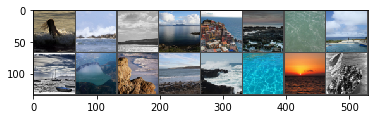

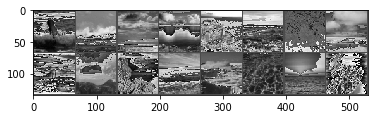

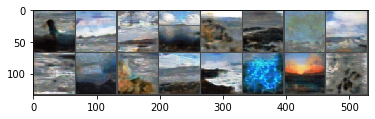

In [ ]:
print("test on 16 images:")
test_dataiter = iter(test_data)
test_real, _ = test_dataiter.next()
test_images = test_real.clone().cpu() 
test_images = [torchvision.transforms.ToPILImage()(x) for x in test_images]
test_images = [torchvision.transforms.Grayscale()(x) for x in test_images]
test_images = [torchvision.transforms.ToTensor()(x) for x in test_images]
test_real_gray = torch.stack(test_images).cpu()

test_img_orig = test_real[0:16,...]
test_img_gray = test_real_gray[0:16,...]
n = (torch.randn(test_img_gray.size()) * .1)
G_test_out = G(torch.cat((test_img_gray, n), 1))
show_imgs(test_img_orig)
show_imgs(test_img_gray)
show_imgs(G_test_out)